In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class GenericNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions=1, is_actor=True):
        super().__init__()

        self.is_actor = is_actor

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        if self.is_actor:
            # Actor outputs mean and log std
            self.mu = nn.Linear(fc2_dims, n_actions)
            self.log_sigma = nn.Linear(fc2_dims, n_actions)
        else:
            # Critic outputs state value
            self.value = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        if self.is_actor:
            mu = self.mu(x)
            log_sigma = self.log_sigma(x)
            return mu, log_sigma
        else:
            value = self.value(x)
            return value

In [3]:
class Agent(object):
    
    def __init__(self, alpha, beta, input_dims, gamma=0.99, n_actions=1, layer1_size=64, layer2_size=64, n_outputs=1):
        self.gamma = gamma
        self.log_probs = None
        self.n_outputs = n_outputs
        
        self.actor = GenericNetwork(alpha, input_dims, layer1_size, layer2_size, n_actions=n_actions, is_actor=True)
        self.critic = GenericNetwork(beta, input_dims, layer1_size, layer2_size, n_actions=n_actions, is_actor=False)
    
    def choose_actions(self, observation, evaluate=False):
        state = T.tensor(observation, dtype=T.float).to(self.actor.device)
        
        mu, log_sigma = self.actor(state)
        log_sigma = T.clamp(log_sigma, -20, 2)
        sigma = T.exp(log_sigma)
        
        dist = T.distributions.Normal(mu, sigma)
        
        if evaluate:
            raw_action = mu
        else:
            raw_action = dist.rsample()
        
        action = T.tanh(raw_action)
        
        log_prob = dist.log_prob(raw_action)
        log_prob -= T.log(1 - action.pow(2) + 1e-6)
        self.log_probs = log_prob.sum()
        
        return action.detach().cpu().numpy()

    def learn(self, state, reward, new_state, done):
        state = T.tensor(state, dtype=T.float).to(self.actor.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.actor.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        
        critic_value = self.critic(state)
        critic_value_ = self.critic(new_state)
        
        delta = reward + self.gamma * critic_value_ * (1 - float(done)) - critic_value
        
        actor_loss = -self.log_probs * delta.detach()
        critic_loss = delta.pow(2)
        
        # Separate backward passes
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
        
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
    
    def save_models(self, path="models"):
        T.save(self.actor.state_dict(), f"{path}/actor.pth")
        T.save(self.critic.state_dict(), f"{path}/critic.pth")
    
    def load_models(self, path="models"):
        self.actor.load_state_dict(T.load(f"{path}/actor.pth"))
        self.critic.load_state_dict(T.load(f"{path}/critic.pth"))


In [7]:
env = gym.make('MountainCarContinuous-v0')

agent = Agent(
    alpha=1e-3,   
    beta=1e-2,     
    input_dims=env.observation_space.shape[0],
    gamma=0.99,
    layer1_size=256,
    layer2_size=256
)

score_history = []
num_episodes = 1
for i in range(num_episodes):
    done = False
    score = 0
    step = 0
    observation, _ = env.reset()
    
    while not done:
        action = np.array(agent.choose_actions(observation)).reshape((1,))
        observation_, reward, done, _, _ = env.step(action)
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        score += reward
        step += 1
        
        if step % 100 == 0:
            print(f"Episode {i}, Step {step}, Score: {score:.2f}")
    
    score_history.append(score)
    print('Episode ', i, ' score: %.2f' % score)

agent.save_models()

Episode 0, Step 100, Score: -1.37
Episode 0, Step 200, Score: -1.80
Episode 0, Step 300, Score: -1.95
Episode 0, Step 400, Score: -2.05
Episode 0, Step 500, Score: -2.12
Episode 0, Step 600, Score: -2.20
Episode 0, Step 700, Score: -2.25
Episode 0, Step 800, Score: -2.28
Episode 0, Step 900, Score: -2.31
Episode 0, Step 1000, Score: -2.34
Episode 0, Step 1100, Score: -2.38
Episode 0, Step 1200, Score: -2.40
Episode 0, Step 1300, Score: -2.42
Episode 0, Step 1400, Score: -2.44
Episode 0, Step 1500, Score: -2.45
Episode 0, Step 1600, Score: -2.46
Episode 0, Step 1700, Score: -2.48
Episode 0, Step 1800, Score: -2.50
Episode 0, Step 1900, Score: -2.51
Episode 0, Step 2000, Score: -2.53
Episode 0, Step 2100, Score: -2.54
Episode 0, Step 2200, Score: -2.55
Episode 0, Step 2300, Score: -2.55
Episode 0, Step 2400, Score: -2.57
Episode 0, Step 2500, Score: -2.58
Episode 0, Step 2600, Score: -2.60
Episode 0, Step 2700, Score: -2.63
Episode 0, Step 2800, Score: -2.65
Episode 0, Step 2900, Score: 

ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

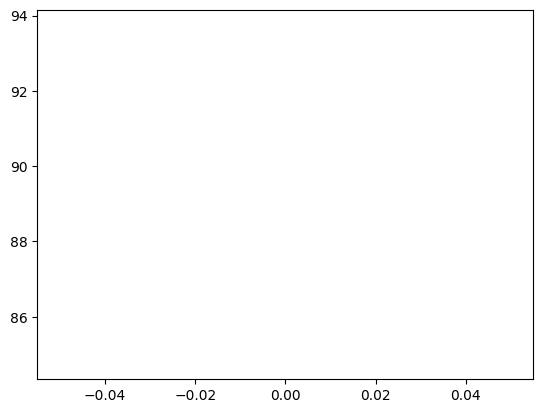

In [8]:
def plot_scores(scores, window=100):
    running_avg = np.convolve(
        scores, np.ones(window)/window, mode='valid'
    )
    
    plt.plot(scores, label="Score")
    plt.plot(range(window-1, len(scores)), running_avg, label="Running Avg (100)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

plot_scores(score_history)

In [ ]:
agent.load_models()

env = gym.make('MountainCarContinuous-v0', render_mode="human")

for episode in range(5):
    done = False
    score = 0
    observation, _ = env.reset()

    while not done:
        action = agent.choose_actions(observation, evaluate=True)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done =  terminated or truncated

    print(f"Test Episode {episode}, Score: {score:.2f}")